In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.python.util import deprecation

deprecation._PRINT_DEPRECATION_WARNINGS = False

In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
from tabulate import tabulate

In [3]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
from tabulate import tabulate

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 113) #classes Number (Total Breeds) 
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %d total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 113 total dog categories.
There are 19528 total dog images.

There are 16405 training dog images.
There are 1582 validation dog images.
There are 1541 test dog images.


In [4]:
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [5]:
from tensorflow.keras.applications import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [7]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 280) & (prediction >= 151) ) 

In [8]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# # pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████████████████████████████████████████████████████████████████████████| 1541/1541 [01:10<00:00, 21.79it/s]


In [10]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # create and configure augmented image generator
# datagen = ImageDataGenerator(
#     width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
#     horizontal_flip=True) # randomly flip images horizontally

# # fit augmented image generator on data
# datagen.fit(train_tensors)

# Importing Pre Trained model to use it weight to train our Model

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

In [10]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3), trainable=False)

In [11]:
#we freeze the output layer of the pretrained model and change the last dense layer with our possible classes which is 135.
model = tf.keras.Sequential([
    
    pretrained_model,
    tf.keras.layers.Dense(113, activation='softmax')

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 113)               144753    
                                                                 
Total params: 2,402,737
Trainable params: 144,753
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
from keras.optimizers import Adam, Adamax
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [13]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/3_epochs.hdf5', 
                               verbose=1, save_best_only=True)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=25),
    checkpointer,
]

In [14]:
history=model.fit(train_tensors, train_targets,
                  validation_data=(valid_tensors, valid_targets),
                  epochs=3,callbacks=my_callbacks)

Epoch 1/3


C:\Users\differenz85\.conda\envs\dog_env\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


513/513 [==============================] - ETA: 0s - loss: 0.7641 - accuracy: 0.8080
Epoch 1: val_loss improved from inf to 0.38933, saving model to saved_models\3_epochs.hdf5
513/513 [==============================] - 267s 505ms/step - loss: 0.7641 - accuracy: 0.8080 - val_loss: 0.3893 - val_accuracy: 0.8837
Epoch 2/3
513/513 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9308
Epoch 2: val_loss improved from 0.38933 to 0.33712, saving model to saved_models\3_epochs.hdf5
513/513 [==============================] - 251s 489ms/step - loss: 0.2353 - accuracy: 0.9308 - val_loss: 0.3371 - val_accuracy: 0.8887
Epoch 3/3
513/513 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9558
Epoch 3: val_loss improved from 0.33712 to 0.30066, saving model to saved_models\3_epochs.hdf5
513/513 [==============================] - 247s 481ms/step - loss: 0.1562 - accuracy: 0.9558 - val_loss: 0.3007 - val_accuracy: 0.9109


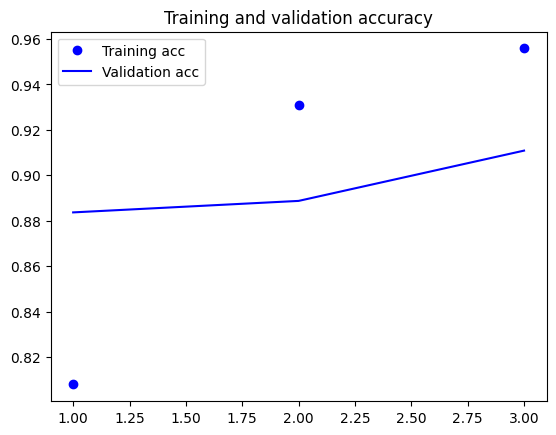

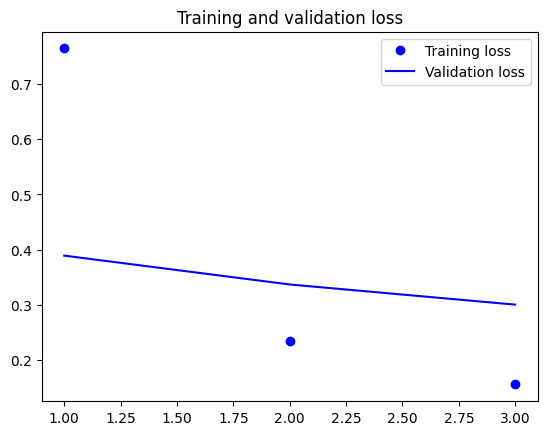

In [15]:
import cv2
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model.save("3_e_Of_113.hdf5")

In [17]:
history=model.fit(train_tensors, train_targets,
                  validation_data=(valid_tensors, valid_targets),
                  epochs=2,callbacks=my_callbacks)

Epoch 1/2
513/513 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9690
Epoch 1: val_loss improved from 0.30066 to 0.29335, saving model to saved_models\3_epochs.hdf5
513/513 [==============================] - 257s 501ms/step - loss: 0.1126 - accuracy: 0.9690 - val_loss: 0.2934 - val_accuracy: 0.9064
Epoch 2/2
513/513 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9778
Epoch 2: val_loss improved from 0.29335 to 0.28596, saving model to saved_models\3_epochs.hdf5
513/513 [==============================] - 243s 473ms/step - loss: 0.0852 - accuracy: 0.9778 - val_loss: 0.2860 - val_accuracy: 0.9153


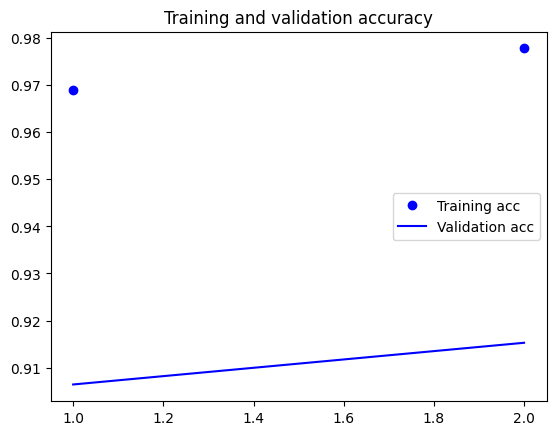

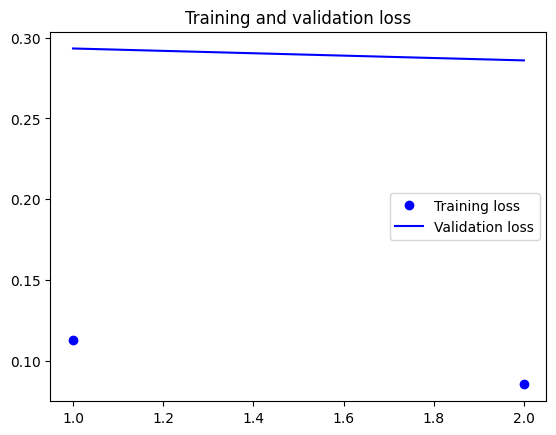

In [18]:
import cv2
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model.save("5_e_Of_113.hdf5")

In [20]:
opt = Adamax(lr=0.0002)
epochs = 5
batch_size = 64


history=model.fit(train_tensors, train_targets,
                  validation_data=(valid_tensors, valid_targets),
                  epochs=epochs,batch_size=batch_size,callbacks=my_callbacks,verbose=1)

Epoch 1/5


C:\Users\differenz85\.conda\envs\dog_env\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:99: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


257/257 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9878
Epoch 1: val_loss improved from 0.28596 to 0.28318, saving model to saved_models\3_epochs.hdf5
257/257 [==============================] - 241s 937ms/step - loss: 0.0595 - accuracy: 0.9878 - val_loss: 0.2832 - val_accuracy: 0.9115
Epoch 2/5
257/257 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9893
Epoch 2: val_loss improved from 0.28318 to 0.28018, saving model to saved_models\3_epochs.hdf5
257/257 [==============================] - 246s 958ms/step - loss: 0.0526 - accuracy: 0.9893 - val_loss: 0.2802 - val_accuracy: 0.9147
Epoch 3/5
257/257 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9900
Epoch 3: val_loss did not improve from 0.28018
257/257 [==============================] - 238s 927ms/step - loss: 0.0480 - accuracy: 0.9900 - val_loss: 0.2816 - val_accuracy: 0.9147
Epoch 4/5
257/257 [==============================] - ETA: 0s - loss: 0.0442 - accur

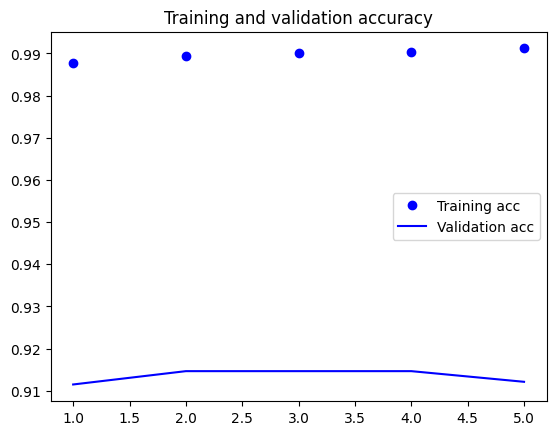

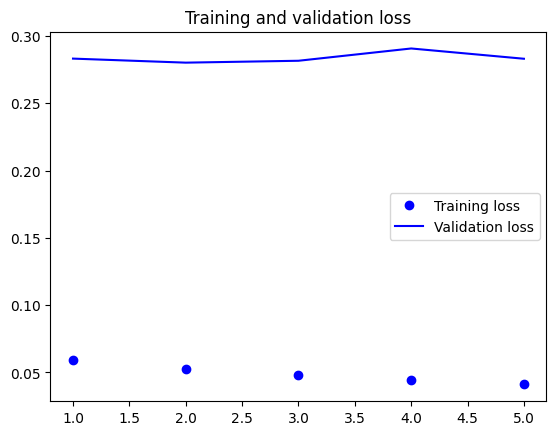

In [21]:
import cv2
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
model.save("10_e_Of_113.hdf5")

In [25]:
# model.load_weights('saved_models/weighh.hdf5')

In [23]:
score, acc = model.evaluate(test_tensors, test_targets)
print('Test Loss =', score)
print('Test Accuracy =', acc*100)

49/49 [==============================] - 32s 550ms/step - loss: 0.3349 - accuracy: 0.8981
Test Loss = 0.3349434733390808
Test Accuracy = 89.81180787086487


In [24]:
score, acc = model.evaluate(valid_tensors, valid_targets)
print('Validation Loss =', score)
print('Validation Accuracy =', acc*100)

50/50 [==============================] - 21s 428ms/step - loss: 0.2831 - accuracy: 0.9121
Validation Loss = 0.28307509422302246
Validation Accuracy = 91.21365547180176


In [26]:
import cv2                
import matplotlib.pyplot as plt   
import pandas as pd
from PIL import Image
def predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = path_to_tensor(img_path).astype('float32')/255
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    df = pd.DataFrame(data={'Prediction': predicted_vector.reshape(-1), 'Dog Breed': dog_names})
    df_sort=df.head(n=5)
    df_sort=df_sort.to_dict('dict')
    df=df.sort_values(['Prediction'], ascending=False)
    df_sort=df.head(n=5)
    df_sort=list(map(lambda x: ({"Prediction": df_sort["Prediction"][x]*100, "Dog Breed": df_sort["Dog Breed"][x]}), list(df_sort["Prediction"].keys())))
    
    fig = plt.figure(figsize=(10,10))
    rows = 2
    columns = 2
    fig.add_subplot(rows, columns, 1)
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.title("Orignal")
    fig.add_subplot(rows, columns, 2)
    imgg=cv2.imread(img_path)
    bigger = cv2.resize(imgg, (244, 244))
    cv_rgbb = cv2.cvtColor(bigger, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgbb)
    plt.title("Compress")
    

    print("Top 5 predictions are :\n")
    return df_sort
#     else:
#         print("No Dog Found !!!!!")
#         return df_sort

1/1 [==============================] - 1s 1s/step
Top 5 predictions are :



[{'Prediction': 97.78780937194824, 'Dog Breed': 'siberian_husky'},
 {'Prediction': 2.1032365038990974, 'Dog Breed': 'Alaskan_malamute'},
 {'Prediction': 0.07297853589989245, 'Dog Breed': 'Akita'},
 {'Prediction': 0.015477479610126466, 'Dog Breed': 'Border_collie'},
 {'Prediction': 0.0036224646464688703, 'Dog Breed': 'Australian_shepherd'}]

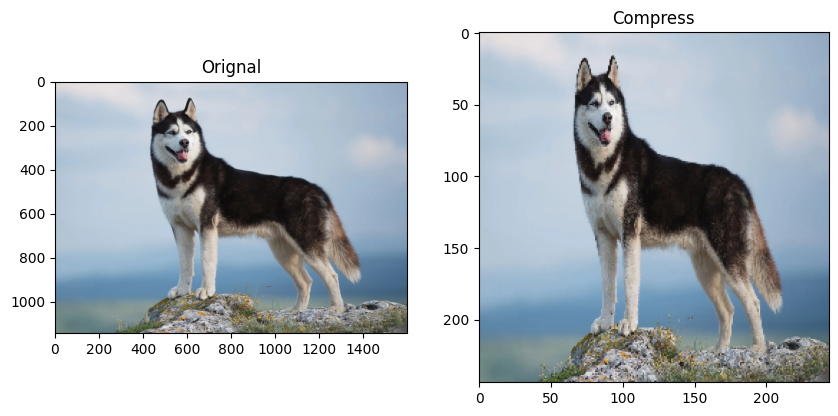

In [27]:
predict_breed('Test_images/1.jpg')

1/1 [==============================] - 0s 43ms/step
Top 5 predictions are :



[{'Prediction': 99.99319314956665, 'Dog Breed': 'siberian_husky'},
 {'Prediction': 0.006336477235890925, 'Dog Breed': 'Alaskan_malamute'},
 {'Prediction': 9.93412299976626e-05, 'Dog Breed': 'Great_dane'},
 {'Prediction': 9.169337431558233e-05, 'Dog Breed': 'Greyhound'},
 {'Prediction': 5.457692964228045e-05, 'Dog Breed': 'Canaan_dog'}]

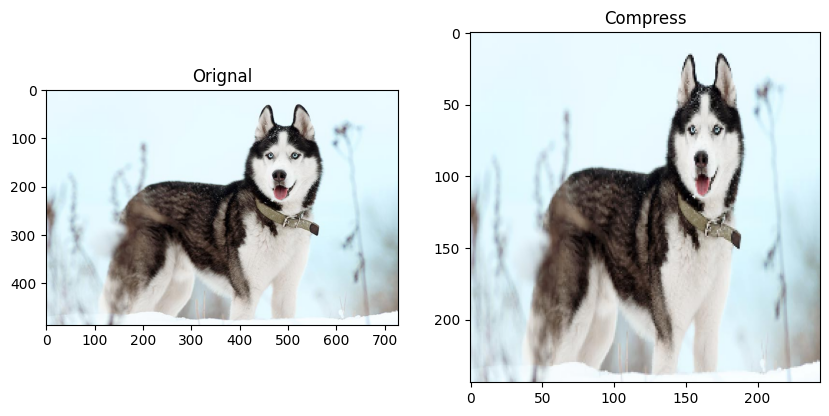

In [28]:
predict_breed('Test_images/2.jpg')

1/1 [==============================] - 0s 65ms/step
Top 5 predictions are :



[{'Prediction': 99.98599290847778, 'Dog Breed': 'Great_dane'},
 {'Prediction': 0.012114422861486673, 'Dog Breed': 'Greyhound'},
 {'Prediction': 0.0005553629762289347, 'Dog Breed': 'Pointer'},
 {'Prediction': 0.0004959944817528594, 'Dog Breed': 'Borzoi'},
 {'Prediction': 0.0003501518222037703, 'Dog Breed': 'Dalmatian'}]

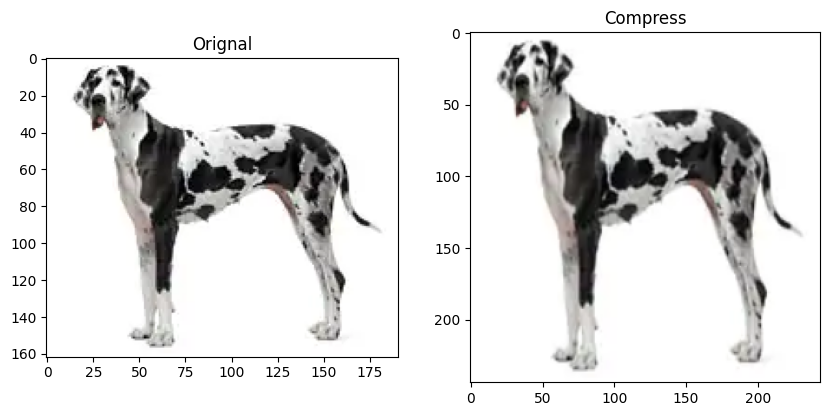

In [29]:
predict_breed('Test_images/3.jpg')

1/1 [==============================] - 0s 44ms/step
Top 5 predictions are :



[{'Prediction': 99.94426369667053, 'Dog Breed': 'Lhasa_apso'},
 {'Prediction': 0.026550021721050143, 'Dog Breed': 'Havanese'},
 {'Prediction': 0.010265703167533502, 'Dog Breed': 'Bearded_collie'},
 {'Prediction': 0.009499449515715241, 'Dog Breed': 'Maltese'},
 {'Prediction': 0.00412020854128059, 'Dog Breed': 'Lowchen'}]

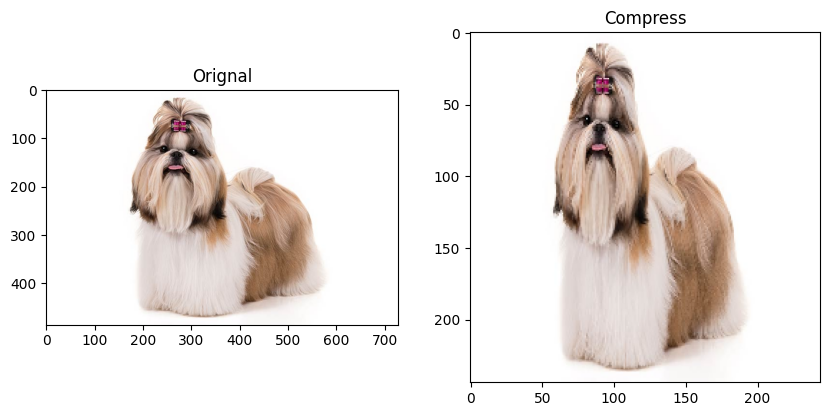

In [31]:
predict_breed('Test_images/5.jpg')

1/1 [==============================] - 0s 43ms/step
Top 5 predictions are :



[{'Prediction': 68.70642900466919, 'Dog Breed': 'Maltese'},
 {'Prediction': 24.827805161476135, 'Dog Breed': 'Lhasa_apso'},
 {'Prediction': 3.176504373550415, 'Dog Breed': 'Pomeranian'},
 {'Prediction': 1.8696622923016548, 'Dog Breed': 'Japanese_chin'},
 {'Prediction': 0.5588958039879799, 'Dog Breed': 'Yorkshire_terrier'}]

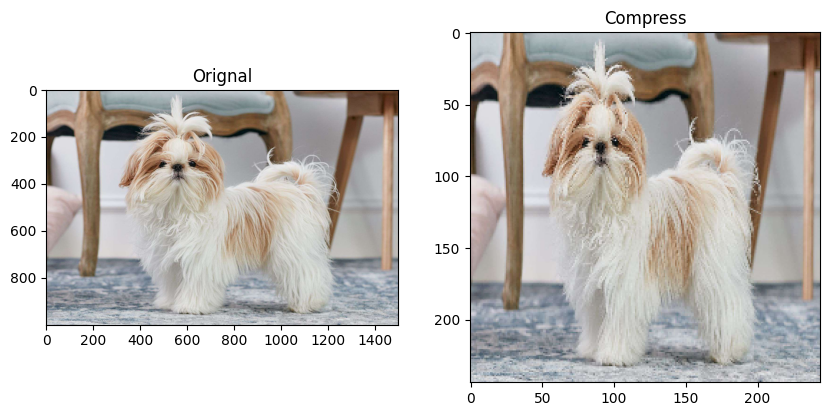

In [33]:
predict_breed('Test_images/7.jpg')

1/1 [==============================] - 0s 66ms/step
Top 5 predictions are :



[{'Prediction': 99.68986511230469, 'Dog Breed': 'Labrador_retriever'},
 {'Prediction': 0.1430740812793374, 'Dog Breed': 'Anatolian_shepherd_dog'},
 {'Prediction': 0.10214989306405187, 'Dog Breed': 'Chesapeake_bay_retriever'},
 {'Prediction': 0.0530002755112946, 'Dog Breed': 'Golden_retriever'},
 {'Prediction': 0.007778868894092739, 'Dog Breed': 'Bullmastiff'}]

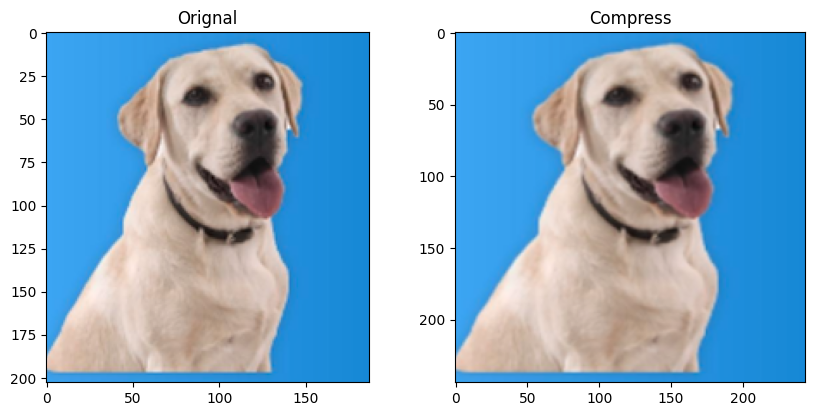

In [34]:
predict_breed('Test_images/8.jpg')

1/1 [==============================] - 0s 56ms/step
Top 5 predictions are :



[{'Prediction': 99.66453909873962, 'Dog Breed': 'French_bulldog'},
 {'Prediction': 0.24814982898533344, 'Dog Breed': 'Boxer'},
 {'Prediction': 0.04594650526996702, 'Dog Breed': 'Bulldog'},
 {'Prediction': 0.019098534539807588, 'Dog Breed': 'Boston_terrier'},
 {'Prediction': 0.007577219366794452, 'Dog Breed': 'Chow_chow'}]

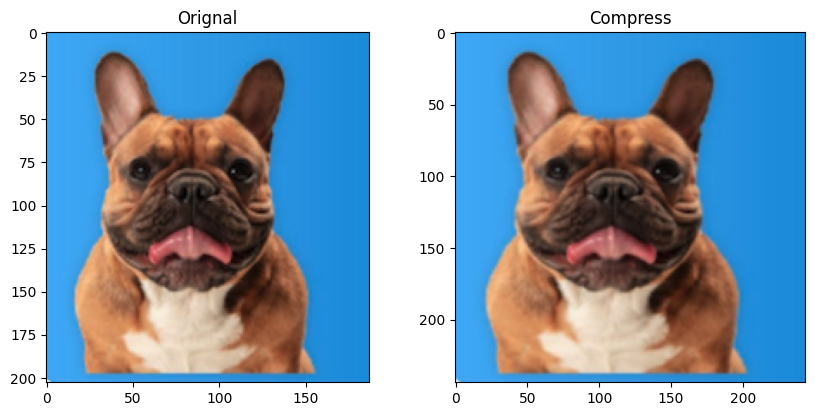

In [35]:
predict_breed('Test_images/9.jpg')

1/1 [==============================] - 0s 90ms/step
Top 5 predictions are :



[{'Prediction': 99.71261620521545,
  'Dog Breed': 'Cavalier_king_charles_spaniel'},
 {'Prediction': 0.2261711284518242, 'Dog Breed': 'English_toy_spaniel'},
 {'Prediction': 0.035463328822515905, 'Dog Breed': 'English_springer_spaniel'},
 {'Prediction': 0.016937228792812675, 'Dog Breed': 'Cocker_spaniel'},
 {'Prediction': 0.005095911546959542, 'Dog Breed': 'English_cocker_spaniel'}]

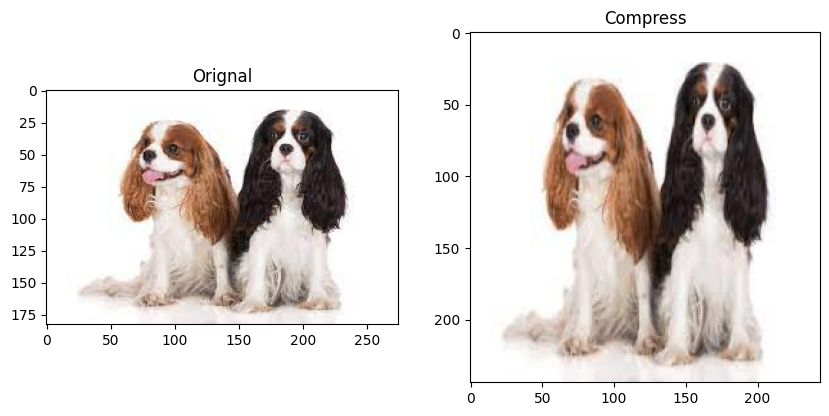

In [36]:
predict_breed('Test_images/10.jpg')

1/1 [==============================] - 0s 42ms/step
Top 5 predictions are :



[{'Prediction': 99.92777705192566,
  'Dog Breed': 'Cavalier_king_charles_spaniel'},
 {'Prediction': 0.03852828813251108, 'Dog Breed': 'English_toy_spaniel'},
 {'Prediction': 0.010896543972194195,
  'Dog Breed': 'Irish_red_and_white_setter'},
 {'Prediction': 0.009491208766121417, 'Dog Breed': 'Japanese_chin'},
 {'Prediction': 0.005451226388686337, 'Dog Breed': 'English_springer_spaniel'}]

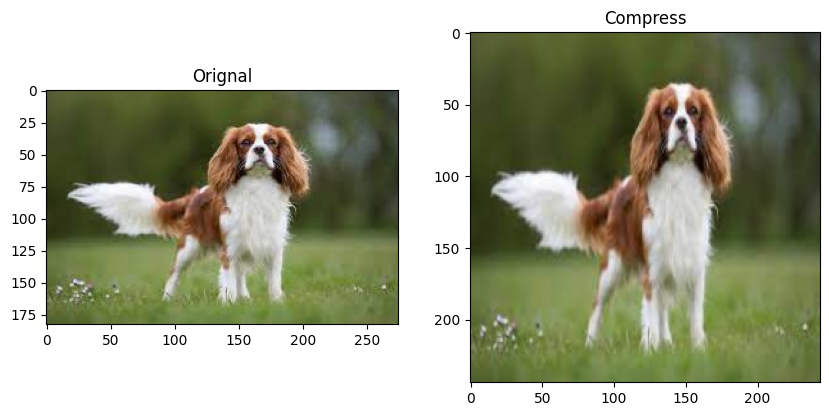

In [37]:
predict_breed('Test_images/11.jpg')

1/1 [==============================] - 0s 42ms/step
Top 5 predictions are :



[{'Prediction': 99.8572826385498, 'Dog Breed': 'siberian_husky'},
 {'Prediction': 0.1398859778419137, 'Dog Breed': 'Alaskan_malamute'},
 {'Prediction': 0.0010202969860984012, 'Dog Breed': 'Canaan_dog'},
 {'Prediction': 0.0005765969945059624, 'Dog Breed': 'Akita'},
 {'Prediction': 0.00026065913516504224, 'Dog Breed': 'German_shepherd_dog'}]

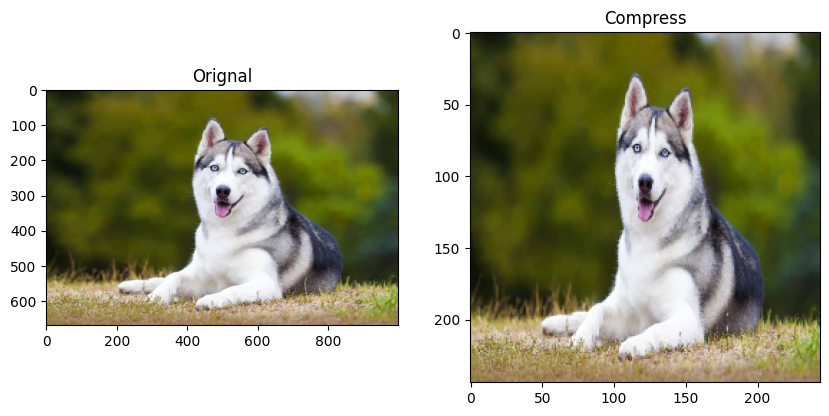

In [38]:
predict_breed('Test_images/12.jpg')

1/1 [==============================] - 0s 42ms/step
Top 5 predictions are :



[{'Prediction': 99.94496703147888, 'Dog Breed': 'siberian_husky'},
 {'Prediction': 0.04615136131178588, 'Dog Breed': 'Alaskan_malamute'},
 {'Prediction': 0.004964412801200524, 'Dog Breed': 'Akita'},
 {'Prediction': 0.0012441073522495572, 'Dog Breed': 'German_shepherd_dog'},
 {'Prediction': 0.000503242290506023, 'Dog Breed': 'Canaan_dog'}]

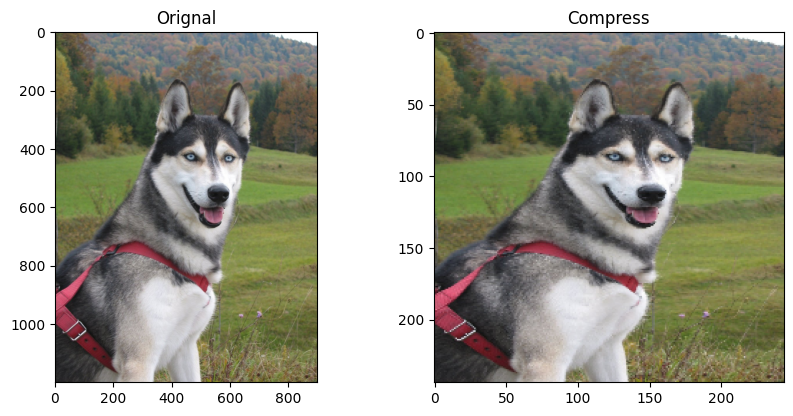

In [39]:
predict_breed('Test_images/13.jpg')

1/1 [==============================] - 0s 42ms/step
Top 5 predictions are :



[{'Prediction': 87.6991868019104, 'Dog Breed': 'Golden_retriever'},
 {'Prediction': 12.273263931274414, 'Dog Breed': 'Labrador_retriever'},
 {'Prediction': 0.011804613313870504, 'Dog Breed': 'Pembroke_welsh_corgi'},
 {'Prediction': 0.005212680844124407,
  'Dog Breed': 'Nova_scotia_duck_tolling_retriever'},
 {'Prediction': 0.004122708924114704, 'Dog Breed': 'English_cocker_spaniel'}]

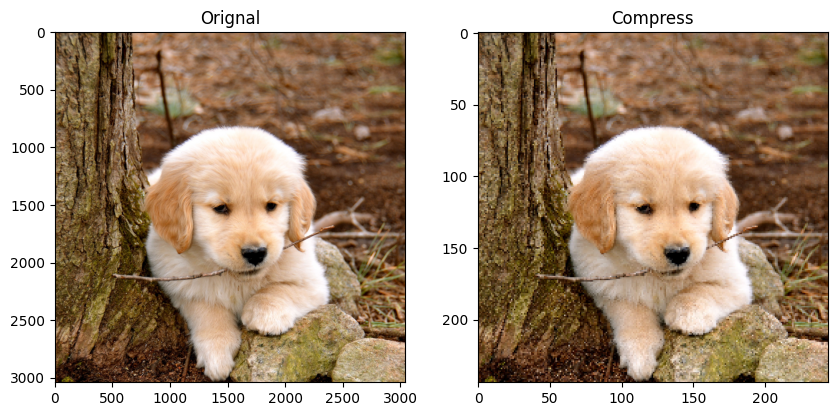

In [41]:
predict_breed('Test_images/15.jpg')

# Loading the save model and do Prediction. Just run below cells to Predict the Dog Breed Without training the model.

In [9]:
import os
import cv2                
import matplotlib.pyplot as plt   
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [10]:
model=tf.keras.models.load_model(('10_e_Of_113.hdf5'),compile=False,custom_objects={'KerasLayer':hub.KerasLayer})
dff1=pd.read_csv('dog_breeds.csv')
dog_names=dff1['dog_breeds'].tolist()

In [11]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [12]:
def predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = path_to_tensor(img_path).astype('float32')/255
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    df = pd.DataFrame(data={'Prediction': predicted_vector.reshape(-1), 'Dog Breed': dog_names})
    df_sort=df.head(n=5)
    df_sort=df_sort.to_dict('dict')
    df=df.sort_values(['Prediction'], ascending=False)
    df_sort=df.head(n=5)
    df_sort=list(map(lambda x: ({"Prediction": df_sort["Prediction"][x]*100, "Dog Breed": df_sort["Dog Breed"][x]}), list(df_sort["Prediction"].keys())))
    
    fig = plt.figure(figsize=(10,10))
    rows = 2
    columns = 2
    fig.add_subplot(rows, columns, 1)
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.title("Orignal")
    fig.add_subplot(rows, columns, 2)
    imgg=cv2.imread(img_path)
    bigger = cv2.resize(imgg, (244, 244))
    cv_rgbb = cv2.cvtColor(bigger, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgbb)
    plt.title("Compress")
    

    print("Top 5 predictions are :\n")
    return df_sort
#     else:
#         print("No Dog Found !!!!!")
#         return df_sort

1/1 [==============================] - 0s 393ms/step
Top 5 predictions are :



[{'Prediction': 99.97768998146057, 'Dog Breed': 'Pomeranian'},
 {'Prediction': 0.018274584726896137, 'Dog Breed': 'Chihuahua'},
 {'Prediction': 0.002412996400380507, 'Dog Breed': 'Akita'},
 {'Prediction': 0.001281444747291971, 'Dog Breed': 'Chow_chow'},
 {'Prediction': 0.0001904733721858065, 'Dog Breed': 'american_pit_bull'}]

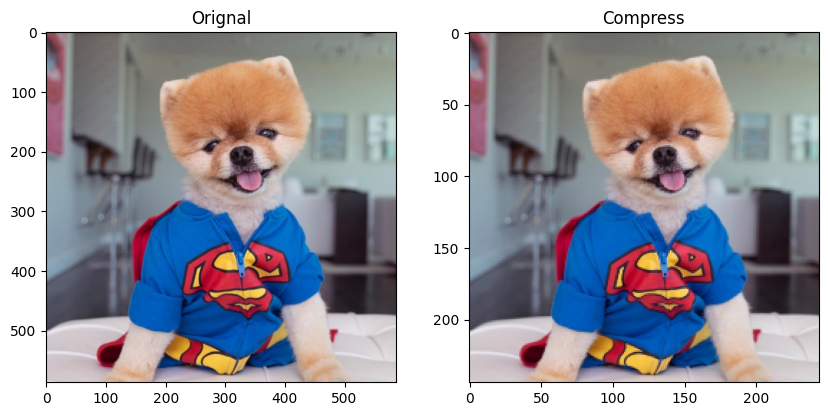

In [13]:
predict_breed('Test_images/16.jpg')